In [1]:
import torch
import random
import numpy
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

In [2]:
hidden_size = 128
test_ratio = 0.05
torch.set_num_threads(6)

In [3]:
# Loading data from text file
label = []
dataset_raw = []
dataset_classed = {}

label_test = []
dataset_raw_test = []
dataset_classed_test = {}

for filename, label_value in {"white_list.txt":1, "black_list.txt":0}.items():
    current_data_set = []
    current_data_set_test = []
    with open(filename,"r") as fp:
        for hospital_name in fp.readlines():
            hospital_name = hospital_name.replace("\n","")
            is_test = test_ratio>random.random()
            if is_test:
                current_data_set.append(hospital_name)
                label.append(label_value)
            else:
                current_data_set_test.append(hospital_name)
                label_test.append(label_value)
    dataset_raw += current_data_set
    dataset_classed[label_value] = current_data_set
    dataset_raw_test += current_data_set_test
    dataset_classed_test[label_value] = current_data_set_test
    
char_list = list(set([y for x in dataset_raw for y in x]))

char_map = { w:i for i,w in enumerate(char_list)}
char_list_size = len(char_list)


In [4]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def charToTensor(ch):
    tensor = torch.zeros(1, char_list_size)
    tensor[0][char_map[ch]] = 1
    return tensor

def lineToTensor(line:str):
    tensor = torch.zeros(len(line), 1, char_list_size)
    for li, ch in enumerate(line):
        if ch in char_map:
            tensor[li][0][char_map[ch]] = 1
    return tensor

In [5]:
def randomChoice(x):
    return x[random.randint(0, len(x) - 1)]

def samplingRandomly():
    category = randomChoice(list(dataset_classed.keys()))
    data = randomChoice(dataset_classed[category])
    data_tensor = lineToTensor(data)
    category_tensor = torch.tensor([category], dtype=torch.long)
    return (category,data,category_tensor,data_tensor)

In [6]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    

In [7]:
rnn = RNN(len(char_list), hidden_size, 2)
# Test net
output, next_hidden = rnn(charToTensor("院"), torch.zeros(1, hidden_size))
def categoryFromOutput(output):
    """
    返回是否正常
    """
    return 0 if output[0][0]>= output[0][1] else 1

print(categoryFromOutput(output))

1


In [8]:
loss_function = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = loss_function(output, category_tensor)
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

In [ ]:
import time
import math
n_iters = 100000
print_every = 100
check_early_stopping = 100
# Keep track of losses for plotting
current_loss = 0
all_losses = []
test_losses = []

increase_count = 5

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category,data,category_tensor,data_tensor = samplingRandomly()
    output, loss = train(category_tensor,data_tensor)
    current_loss += loss
    # Add current loss avg to list of losses
    if iter % check_early_stopping == 0:
        avg_loss = current_loss / check_early_stopping
        output, loss = train(category_tensor,data_tensor)
        current_loss = 0
        all_losses.append(avg_loss)
        loss_test_sum = 0
        for i in range(len(label_test)):
            _, loss_test = train(
                torch.tensor([label_test[i]], dtype=torch.long),
                lineToTensor(dataset_raw_test[i])
            )
            loss_test_sum += loss_test
        avg_loss_test = loss_test_sum/len(label_test)
        test_losses.append(avg_loss_test)
        guess = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print(
            '%d %d%% (%s) %.4f/%.4f %s / %s %s' % (
                iter, 
                iter / n_iters * 100,
                timeSince(start), 
                avg_loss, 
                avg_loss_test,
                data, 
                guess, 
                correct)
        )
        if len(test_losses)>increase_count:
            is_passed = False
            for i in range(increase_count):
                x_1 = test_losses[-(i+1)]
                x_2 = test_losses[-(i+2)]
                if x_1 < x_2:
                    is_passed = True
                    break;
            if not is_passed:
                print("early stopped.")
                break
        

100 0% (3m 17s) 0.1343/0.0023 库伦旗蒙医院 / 1 ✓
200 0% (6m 37s) 0.4384/0.0030 济南乳腺医院 / 0 ✓
300 0% (9m 56s) 0.4256/0.0026 鄯善县妇幼保健站 / 1 ✓
400 0% (13m 17s) 0.2768/0.0022 北京圣保罗男子医院 / 0 ✓
500 0% (16m 40s) 0.2648/0.0022 天门市口腔医院 / 1 ✓
600 0% (20m 3s) 0.3131/0.0018 成都安琪儿妇产医院 / 0 ✓
700 0% (23m 22s) 0.5266/0.0049 滁州市琅琊区人民医院 / 1 ✓
800 0% (26m 44s) 0.5100/0.0023 重庆现代女子医院 / 0 ✓
900 0% (30m 6s) 0.5187/0.0018 郸城县人民医院 / 1 ✓
1000 1% (33m 29s) 0.3833/0.0018 中国人民解放军第二十三医院 / 1 ✓
1100 1% (36m 51s) 0.2727/0.0017 杭州和睦医院 / 0 ✓
1200 1% (40m 14s) 0.3626/0.0018 仙居县中医院 / 1 ✓
1300 1% (43m 37s) 0.1617/0.0014 遵义女子医院 / 0 ✓
1400 1% (47m 1s) 0.3263/0.0016 长沙恒生手外科医院 / 0 ✓
1500 1% (50m 30s) 0.1750/0.0015 云南省康复医院 / 1 ✓
1600 1% (53m 51s) 0.2556/0.0015 广州女子医院 / 0 ✓
1700 1% (57m 11s) 0.3311/0.0015 成都安琪儿妇产医院 / 0 ✓
1800 1% (60m 32s) 0.2911/0.0012 上海万众医院 / 0 ✓
1900 1% (64m 2s) 0.3039/0.0015 重庆职工医学院医院 / 1 ✓
2000 2% (67m 35s) 0.2584/0.0012 铜仁华夏医院 / 0 ✓
2100 2% (70m 52s) 0.1530/0.0010 嘉兴市新塍人民医院 / 1 ✓
2200 2% (74m 10s) 0.2269/0.0009 南京市

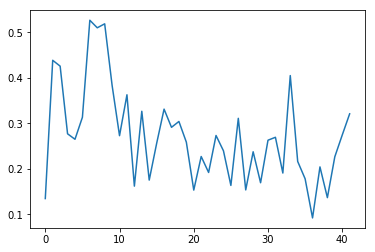

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)
plt.show()

In [19]:
torch.save(rnn, 'rnn.pkl')
rnn_load = torch.load('rnn.pkl')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [21]:
def lineToTensorIgnoreOuter(line:str):
    line_new = "".join([c for c in line if c in char_map])
    if line_new!=line:
        print("(警告：名称变化 %s -> %s)" % (line,line_new))
    tensor = torch.zeros(len(line_new), 1, char_list_size)
    for li, ch in enumerate(line_new):
        if ch in char_map:
            tensor[li][0][char_map[ch]] = 1
    return tensor

def predict(rnn_model:RNN, input_line:str):
    print('\n预测医院 -> %s ->' % input_line)
    with torch.no_grad():
        line_tensor = lineToTensorIgnoreOuter(input_line)
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn_model(line_tensor[i], hidden)
        result = categoryFromOutput(output)
        if  result>0.5:
            print("该医院看上去还算正常，请核实后前往就医！")
        else:
            print("该医院听上去就不是什么正经医院，请仔细核实！")
predict(rnn,"上海玛丽女子医院")
predict(rnn,"江阴市人民医院")
predict(rnn,"汉东省人民医院")
predict(rnn,"京州市玛利亚女子医院")


预测医院 -> 上海玛丽女子医院 ->
该医院听上去就不是什么正经医院，请仔细核实！

预测医院 -> 江阴市人民医院 ->
该医院看上去还算正常，请核实后前往就医！

预测医院 -> 汉东省人民医院 ->
该医院看上去还算正常，请核实后前往就医！

预测医院 -> 京州市玛利亚女子医院 ->
该医院听上去就不是什么正经医院，请仔细核实！
